In [3]:
import pandas as pd
import featuretools as ft
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
%matplotlib inline
color = sns.color_palette()
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_score , recall_score, confusion_matrix
import os
os.listdir('/users/krutarthmajithia/downloads/HomeCredit')
sns.set_style('whitegrid')
pd.options.display.max_columns = 999
pd.options.display.max_info_rows = 125

In [2]:
train = pd.read_csv('/users/krutarthmajithia/downloads/HomeCredit/application_train.csv')
test = pd.read_csv('/users/krutarthmajithia/downloads/HomeCredit/application_test.csv')
bureau_balance = pd.read_csv('/users/krutarthmajithia/downloads/HomeCredit/bureau_balance.csv')
bureau = pd.read_csv('/users/krutarthmajithia/downloads/HomeCredit/bureau.csv')
credit_card_balance = pd.read_csv('/users/krutarthmajithia/downloads/HomeCredit/credit_card_balance.csv')
installments = pd.read_csv('/users/krutarthmajithia/downloads/HomeCredit/installments_payments.csv')
pos_cash = pd.read_csv('/users/krutarthmajithia/downloads/HomeCredit/POS_CASH_balance.csv')
previous_application = pd.read_csv('/users/krutarthmajithia/downloads/HomeCredit/previous_application.csv')


In [4]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [5]:
missing_data(train).T

,COMMONAREA_MEDI,COMMONAREA_AVG,COMMONAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAPARTMENTS_AVG,FONDKAPREMONT_MODE,LIVINGAPARTMENTS_MEDI,LIVINGAPARTMENTS_MODE,LIVINGAPARTMENTS_AVG,FLOORSMIN_MEDI,FLOORSMIN_MODE,FLOORSMIN_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_AVG,YEARS_BUILD_MODE,OWN_CAR_AGE,LANDAREA_MODE,LANDAREA_AVG,LANDAREA_MEDI,BASEMENTAREA_MEDI,BASEMENTAREA_AVG,BASEMENTAREA_MODE,EXT_SOURCE_1,NONLIVINGAREA_MEDI,NONLIVINGAREA_AVG,NONLIVINGAREA_MODE,ELEVATORS_MODE,ELEVATORS_AVG,ELEVATORS_MEDI,WALLSMATERIAL_MODE,APARTMENTS_MODE,APARTMENTS_AVG,APARTMENTS_MEDI,ENTRANCES_MEDI,ENTRANCES_MODE,ENTRANCES_AVG,LIVINGAREA_MEDI,LIVINGAREA_MODE,LIVINGAREA_AVG,HOUSETYPE_MODE,FLOORSMAX_MODE,FLOORSMAX_MEDI,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MODE,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OCCUPATION_TYPE,EXT_SOURCE_3,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,NAME_TYPE_SUITE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,EXT_SOURCE_2,AMT_GOODS_PRICE,AMT_ANNUITY,CNT_FAM_MEMBERS,DAYS_LAST_PHONE_CHANGE,AMT_CREDIT,FLAG_OWN_CAR,FLAG_EMAIL,TARGET,FLAG_PHONE,FLAG_CONT_MOBILE,FLAG_WORK_PHONE,FLAG_EMP_PHONE,FLAG_MOBIL,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,DAYS_ID_PUBLISH,DAYS_REGISTRATION,DAYS_EMPLOYED,DAYS_BIRTH,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT,NAME_FAMILY_STATUS,NAME_EDUCATION_TYPE,NAME_INCOME_TYPE,CNT_CHILDREN,NAME_HOUSING_TYPE,REG_REGION_NOT_LIVE_REGION,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,ORGANIZATION_TYPE,LIVE_CITY_NOT_WORK_CITY,REG_CITY_NOT_WORK_CITY,REG_CITY_NOT_LIVE_CITY,LIVE_REGION_NOT_WORK_REGION,REG_REGION_NOT_WORK_REGION,HOUR_APPR_PROCESS_START,SK_ID_CURR
Total,214865.000000,214865.000000,214865.000000,213514.000000,213514.000000,213514.000000,210295.000000,210199.000000,210199.000000,210199.000000,208642.00000,208642.00000,208642.00000,204488.000000,204488.000000,204488.000000,202929.00000,182590.000000,182590.000000,182590.000000,179943.000000,179943.000000,179943.000000,173378.000000,169682.000000,169682.000000,169682.000000,163891.00000,163891.00000,163891.00000,156341.000000,156061.000000,156061.000000,156061.000000,154828.000000,154828.000000,154828.000000,154350.000000,154350.000000,154350.000000,154297.000000,153020.000000,153020.000000,153020.000000,150007.000000,150007.000000,150007.000000,148431.000000,145755.000000,96391.000000,60965.000000,41519.000000,41519.000000,41519.000000,41519.000000,41519.000000,41519.000000,1292.000000,1021.000000,1021.000000,1021.000000,1021.000000,660.000000,278.000000,12.000000,2.00000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,69.872297,69.872297,69.872297,69.432963,69.432963,69.432963,68.386172,68.354953,68.354953,68.354953,67.84863,67.84863,67.84863,66.497784,66.497784,66.497784,65.99081,59.376738,59.376738,59.376738,58.515956,58.515956,58.515956,56.381073,55.179164,55.179164,55.179164,53.29598,53.29598,53.29598,50.840783,50.749729,50.749729,50.749729,50.348768,50.348768,50.348768,50.193326,50.193326,50.193326,50.176091,49.760822,49.760822,49.760822,48.781019,48.781019,48.781019,48.268517,47.398304,31.345545,19.825307,13.501631,13.501631,13.501631,13.501631,13.501631,13.501631,0.420148,0.332021,0.332021,0.332021,0.332021,0.214626,0.090403,0.003902,0.00065,0.000325,0.0,0.0,0.0,0.0,0.0,

In [6]:
dtype_df = train.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,41
1,float64,65
2,object,16


In [6]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [7]:
print(train.shape)
print(test.shape)

(307511, 122)
(48744, 121)


In [8]:
target_value = train['TARGET'].value_counts()

Text(0.5,0,'Index')

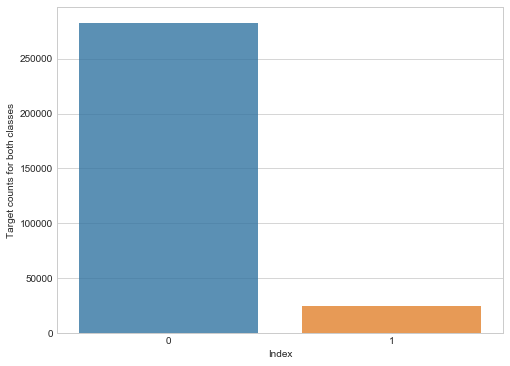

In [9]:
plt.figure(figsize=(8,6))
sns.barplot(target_value.index, target_value.values, alpha=0.8)
plt.ylabel('Target counts for both classes')
plt.xlabel('Index')

Text(0.5,0,'Index')

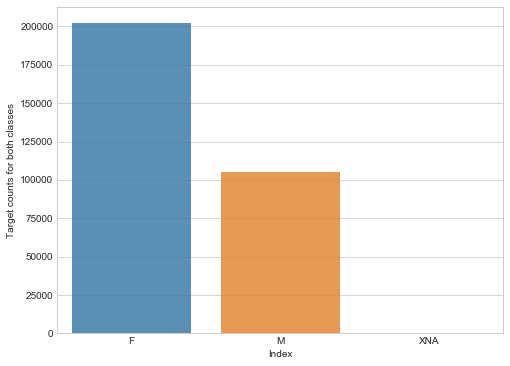

In [10]:
gender_count = train['CODE_GENDER'].value_counts()
plt.figure(figsize=(8,6))
sns.barplot(gender_count.index, gender_count.values, alpha=0.8)
plt.ylabel('Target counts for both classes')
plt.xlabel('Index')

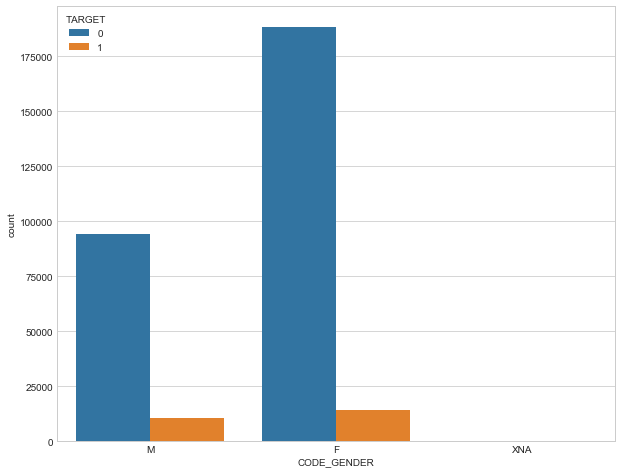

In [11]:
plt.figure(figsize=(10,8))
sns.countplot(x = 'CODE_GENDER', hue='TARGET', data = train)

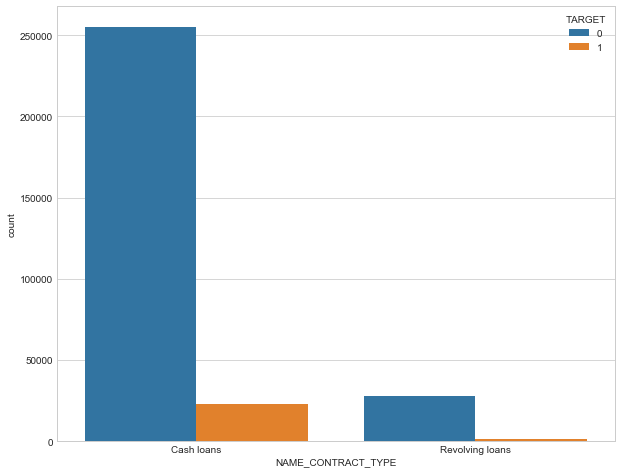

In [12]:
plt.figure(figsize = (10,8))
sns.countplot(x = 'NAME_CONTRACT_TYPE', hue='TARGET',data = train)

Text(0.5,0,'index')

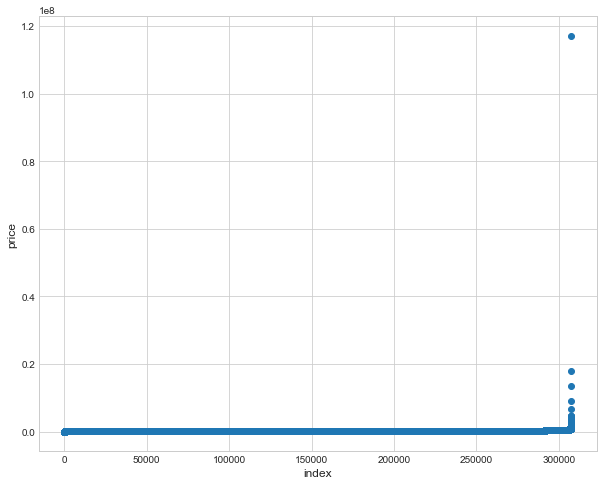

In [13]:
plt.figure(figsize=(10,8))
plt.scatter(range(train.shape[0]), np.sort(train.AMT_INCOME_TOTAL.values))
plt.ylabel('price',fontsize=12)
plt.xlabel('index', fontsize=12)

Text(0.5,0,'Income')

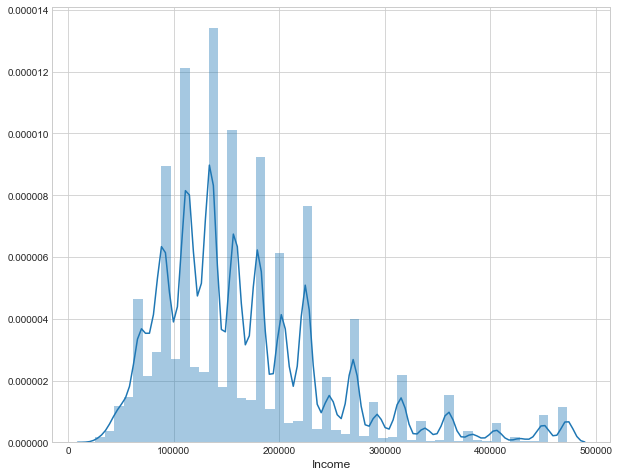

In [14]:
ulimit= np.percentile(train.AMT_INCOME_TOTAL.values, 99)
train['AMT_INCOME_TOTAL'].loc[train['AMT_INCOME_TOTAL']>ulimit]=ulimit

plt.figure(figsize=(10,8))

sns.distplot(train.AMT_INCOME_TOTAL.values, bins=50, kde=True)
plt.xlabel("Income", fontsize=12)


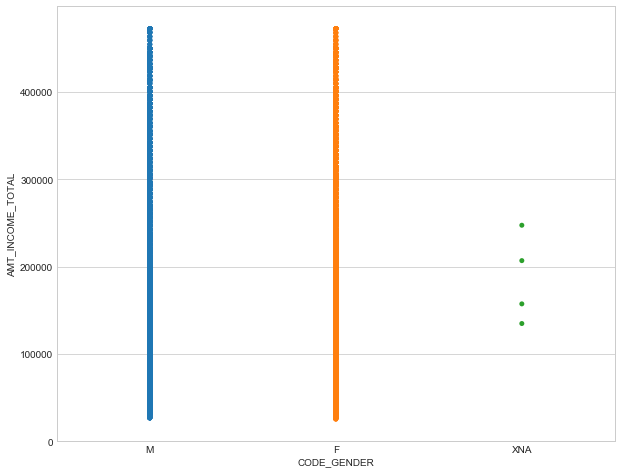

In [15]:
plt.figure(figsize = (10,8))
sns.stripplot(x = 'CODE_GENDER', y='AMT_INCOME_TOTAL', data = train)

In [16]:
Numerical_cols = []
Categorical_cols = []
for col in train.columns:
    if(train[col].dtype == 'int64' or train[col].dtype == 'float64'):
        Numerical_cols.append(col)
        
    elif(train[col].dtype == 'object'):
        Categorical_cols.append(col)
    

In [17]:
train_numerical = train[Numerical_cols]

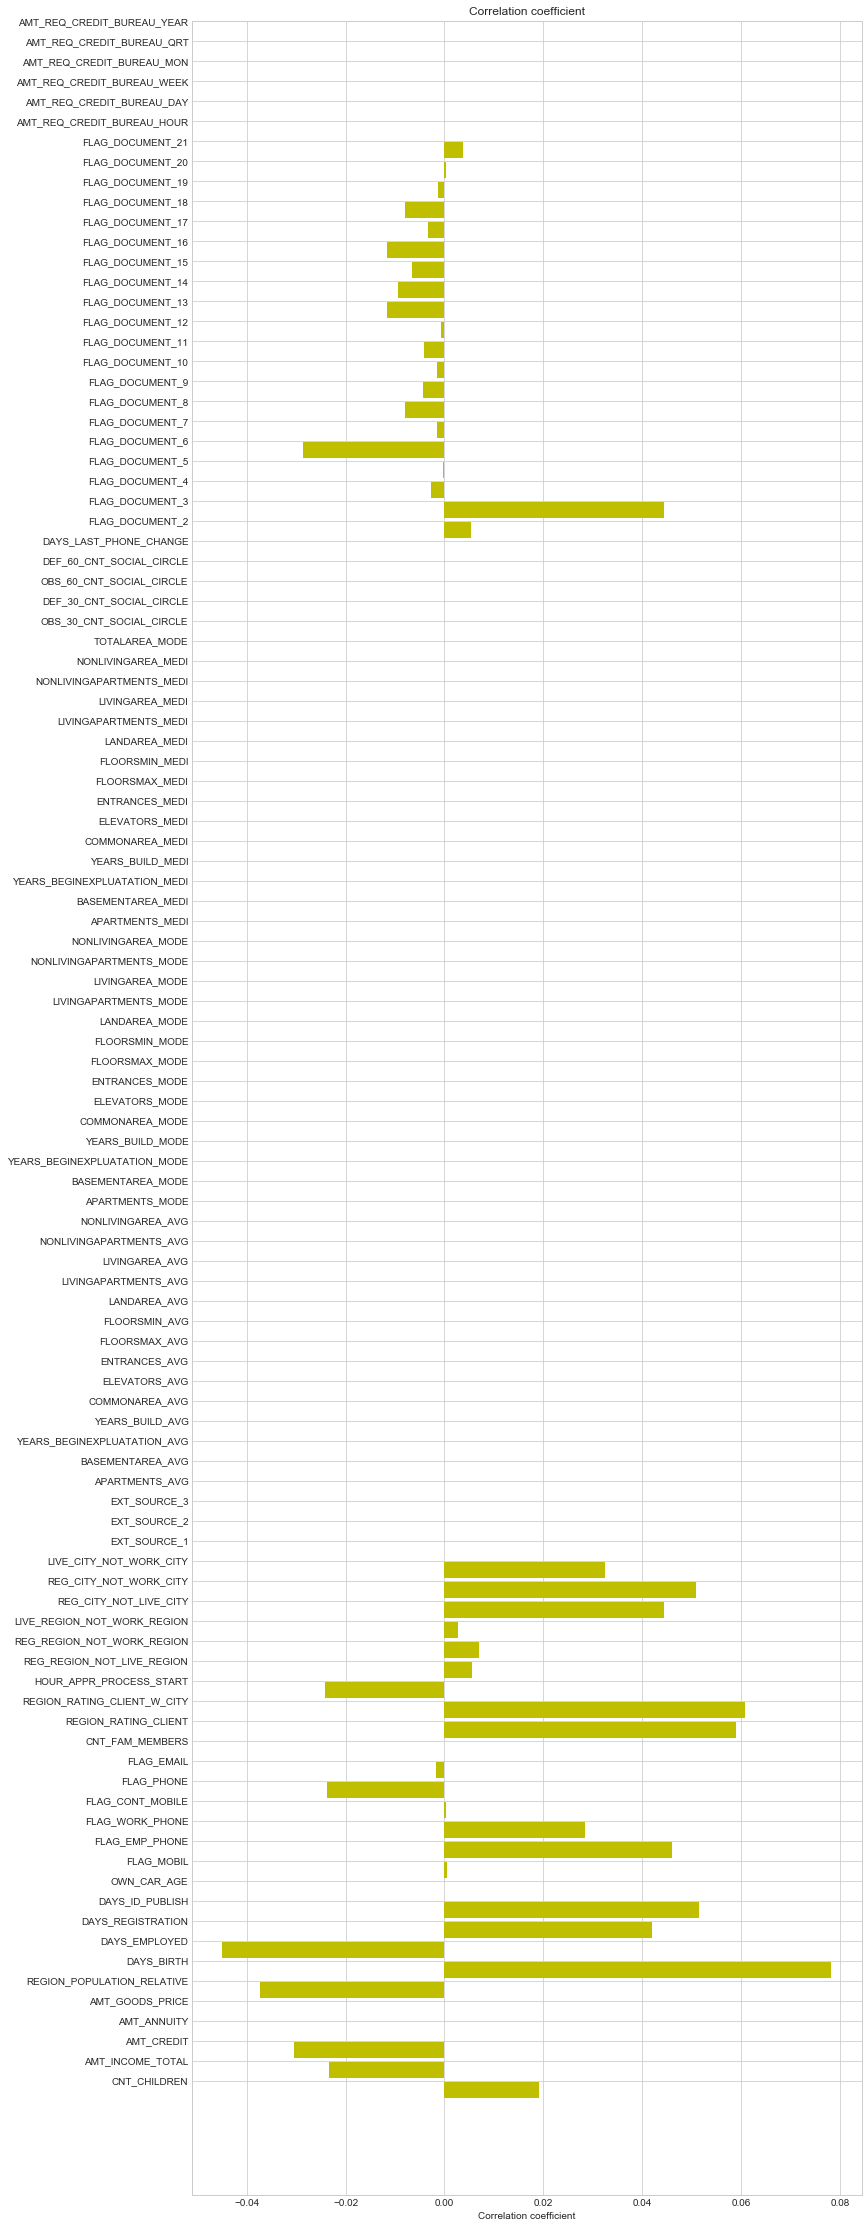

In [18]:
x_cols = [col for col in train_numerical.columns if col not in ['SK_ID_CURR', 'TARGET']]

labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(train_numerical[col].values, train_numerical.TARGET.values)[0,1])
    
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12,40))
rects = ax.barh(ind, np.array(values), color='y')
ax.set_yticks(ind+((width)/2.))
ax.set_yticklabels(labels, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient")
#autolabel(rects)
plt.show()

In [27]:
Categorical_cols

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [28]:
train['NAME_TYPE_SUITE'].value_counts()

Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: NAME_TYPE_SUITE, dtype: int64

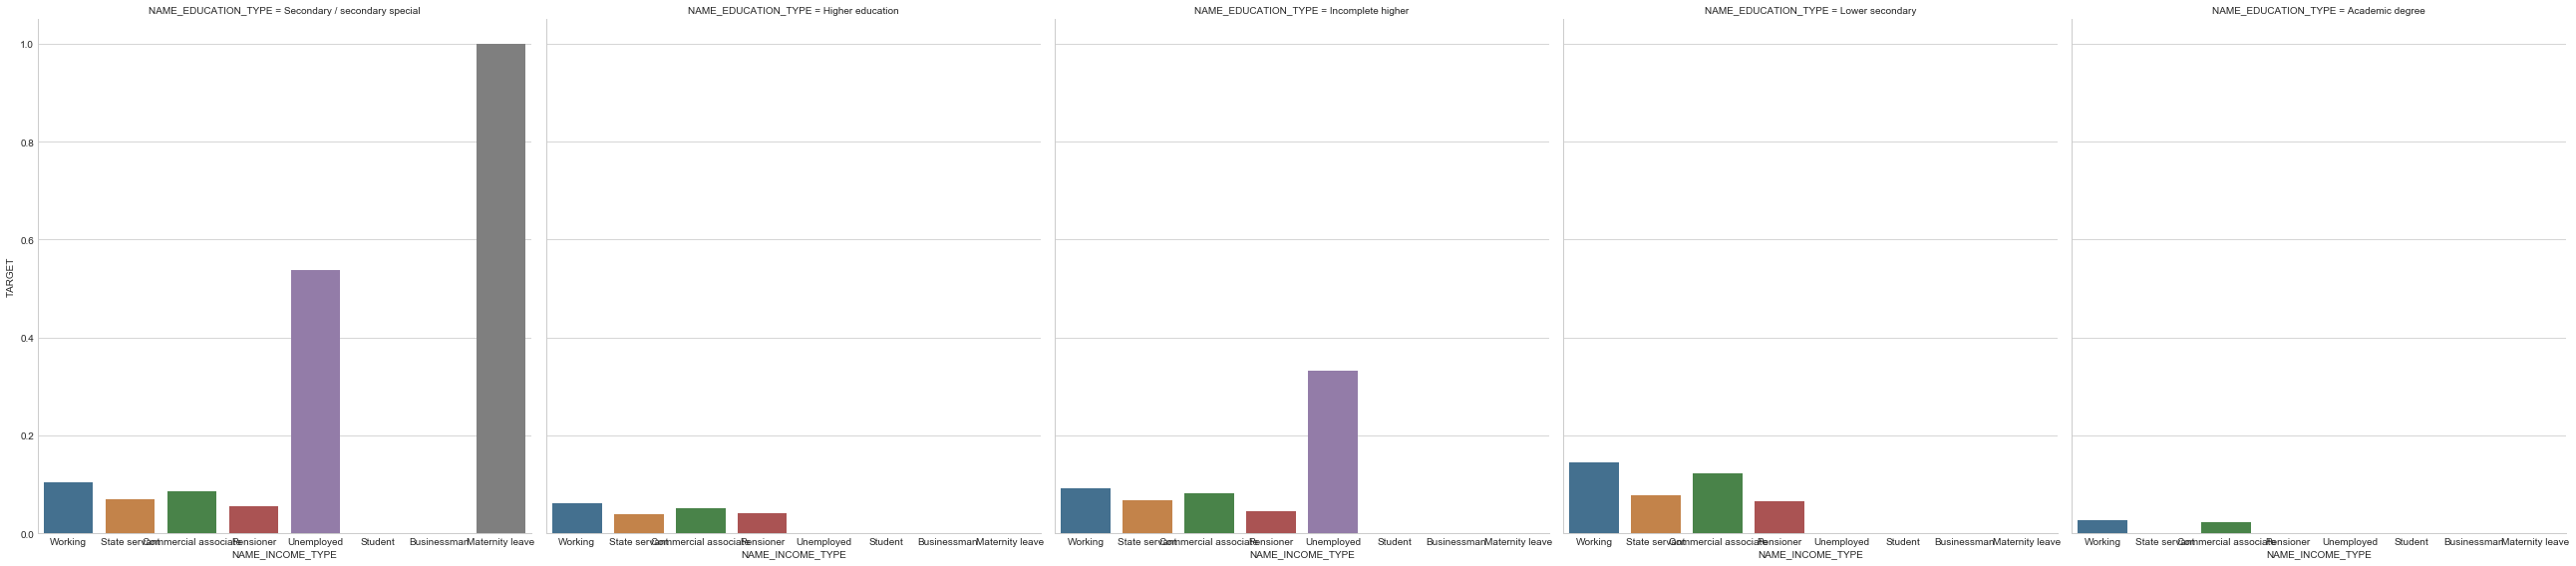

In [41]:
plt.figure(figsize = (12,8))
g = sns.factorplot(x="NAME_INCOME_TYPE", y="TARGET", col="NAME_EDUCATION_TYPE",
                    data=train, saturation=.5,
                    kind="bar", ci=None, aspect=.9, size = 8)

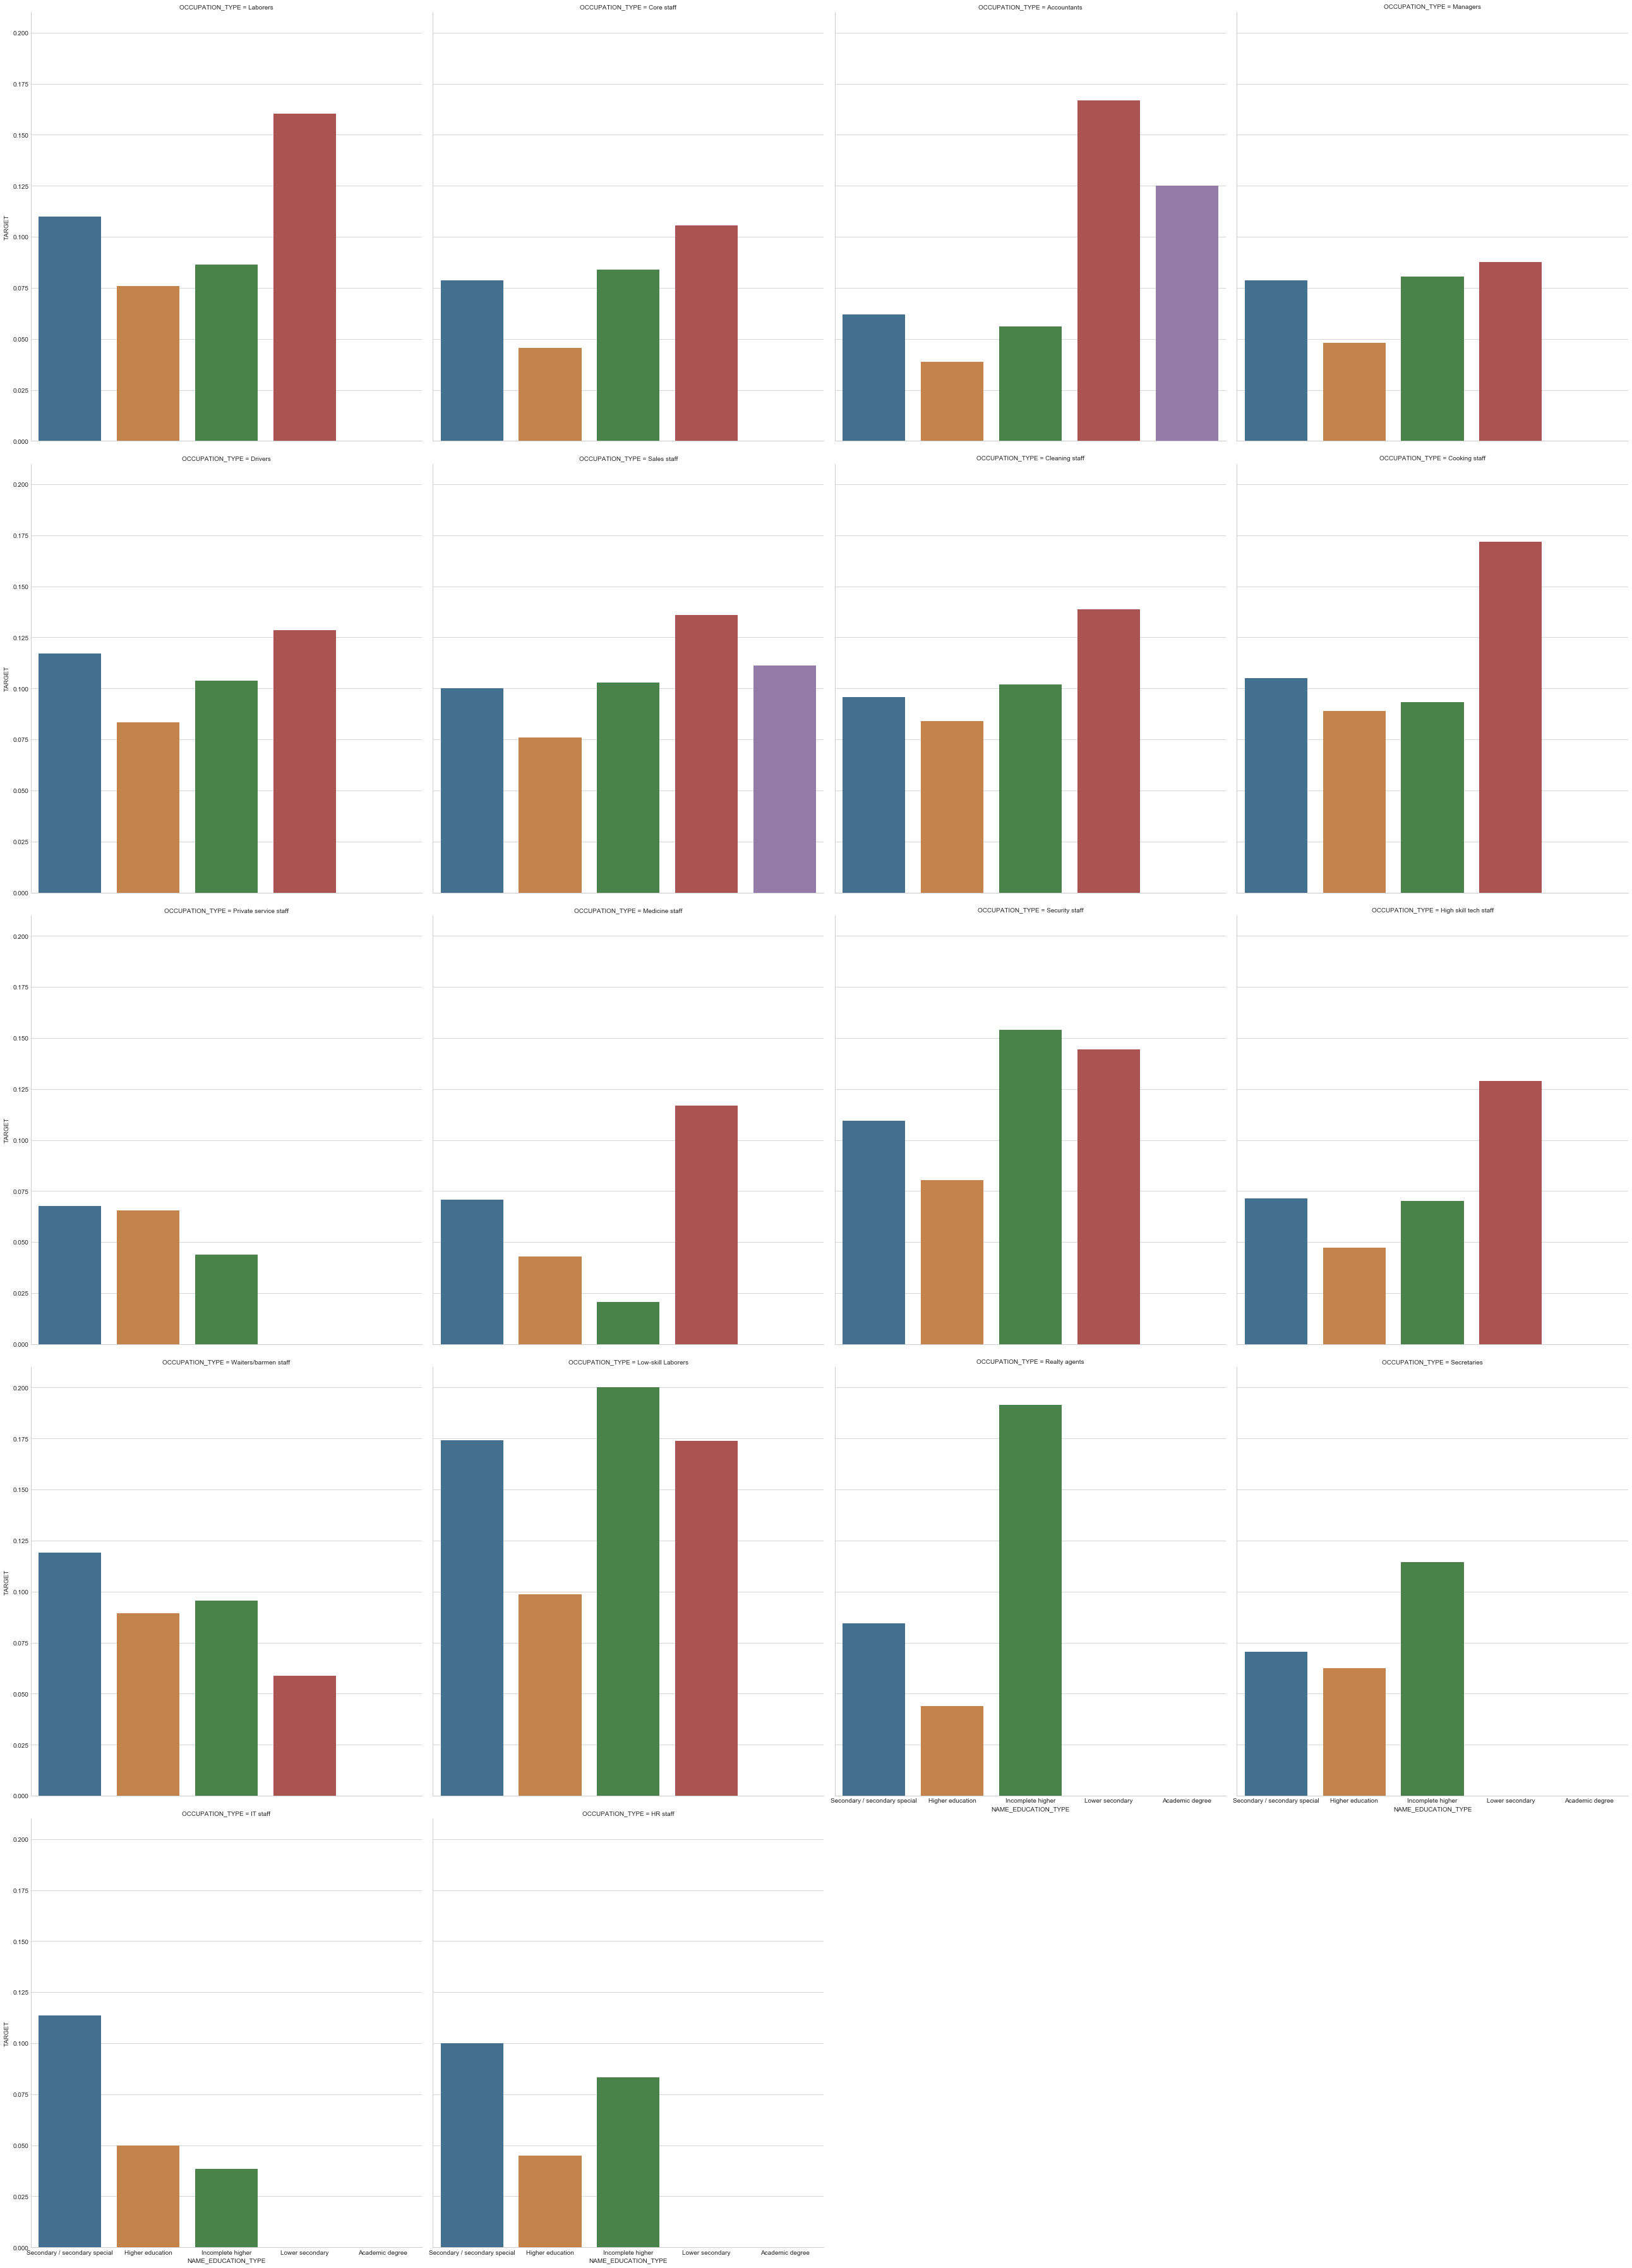

In [43]:
plt.figure(figsize = (12,8))
g = sns.factorplot(x="NAME_EDUCATION_TYPE", y="TARGET", col="OCCUPATION_TYPE",
                    data=train, saturation=.5, col_wrap = 4,
                    kind="bar", ci=None, aspect=.9, size = 10)

In [45]:
organization_count = train['ORGANIZATION_TYPE'].loc[train['TARGET'] == 1]

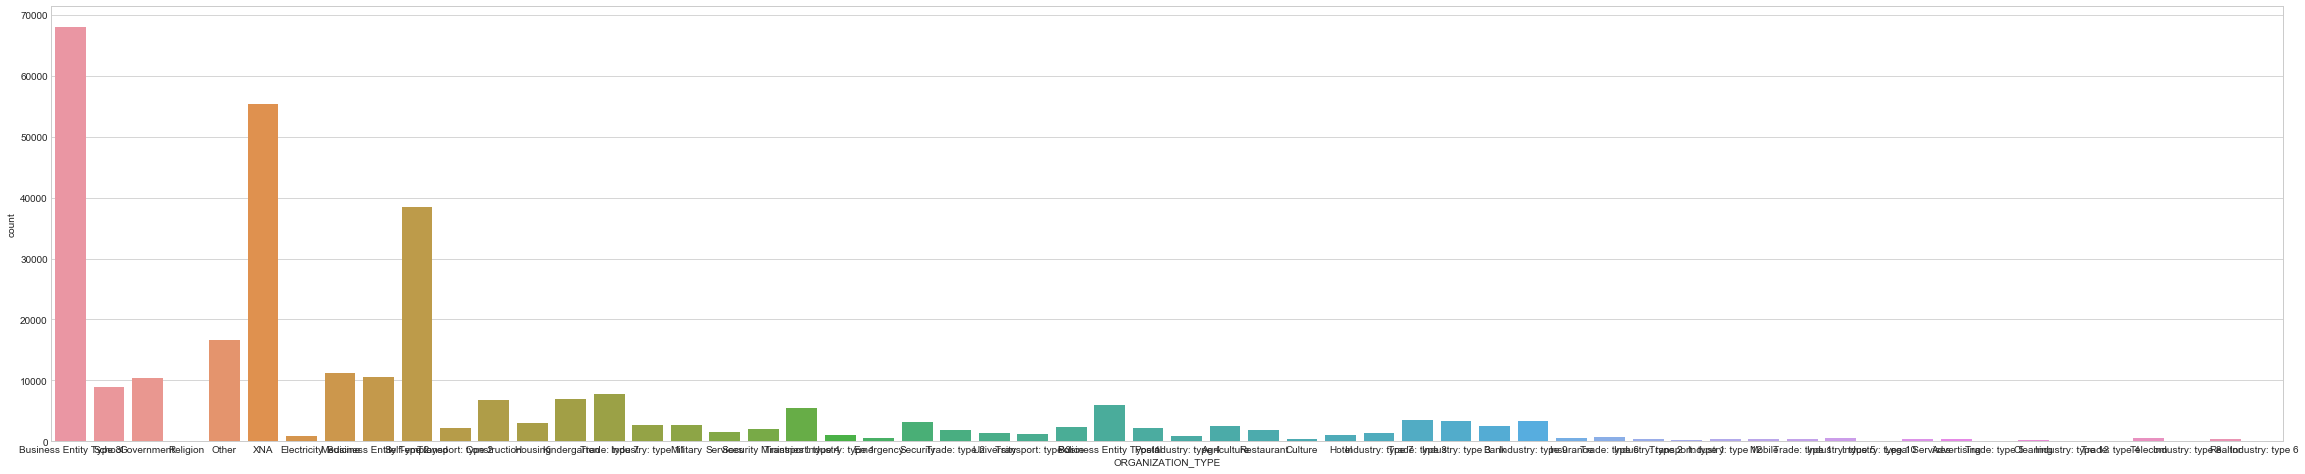

In [52]:
plt.figure(figsize = (40,8))
sns.countplot(train['ORGANIZATION_TYPE'])

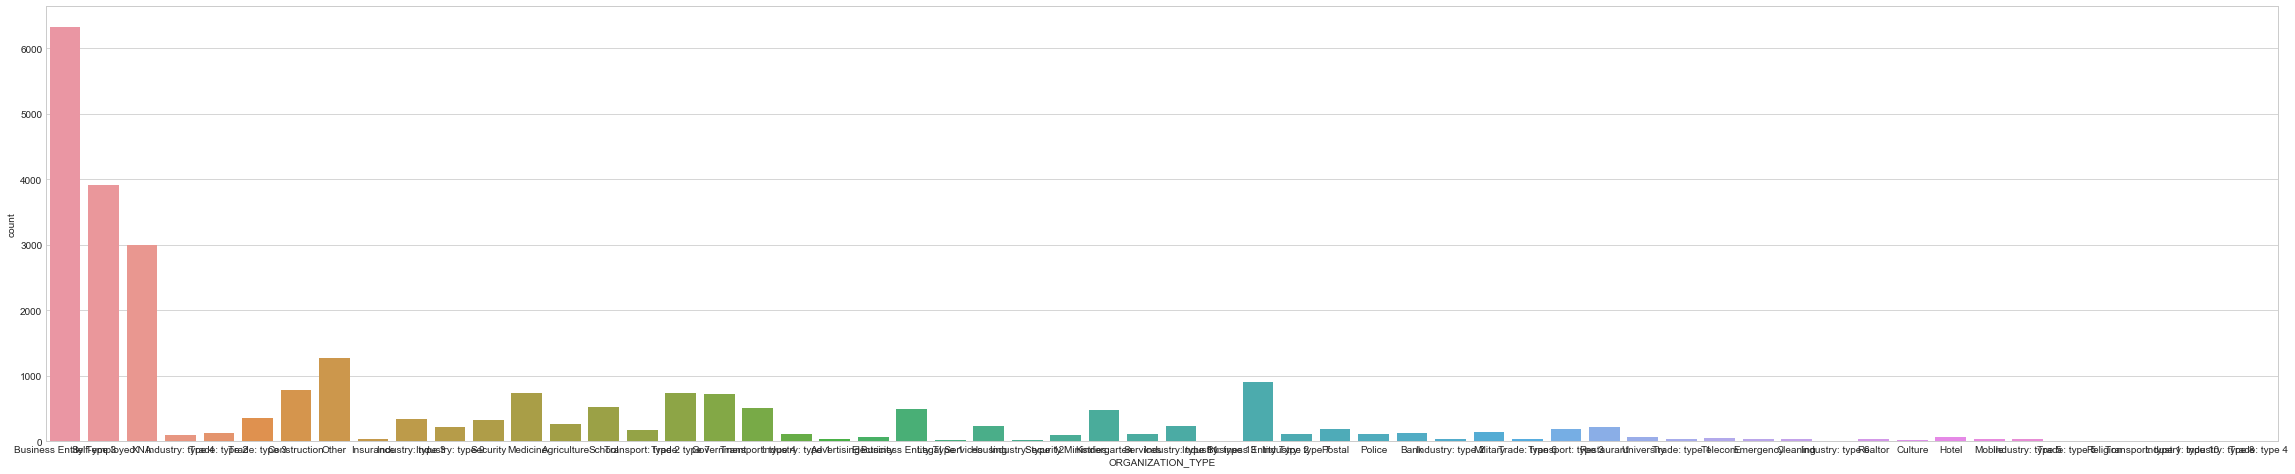

In [53]:
plt.figure(figsize=(40,8))
sns.countplot(organization_count)

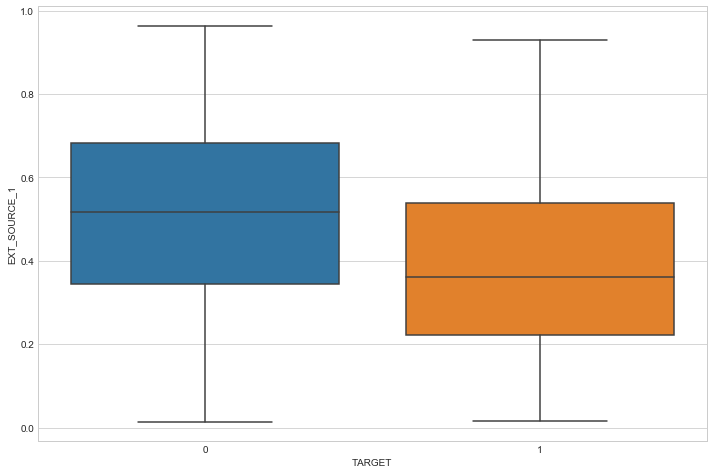

In [54]:
plt.figure(figsize=(12,8))
sns.boxplot(x ='TARGET', y = 'EXT_SOURCE_1', data = train)

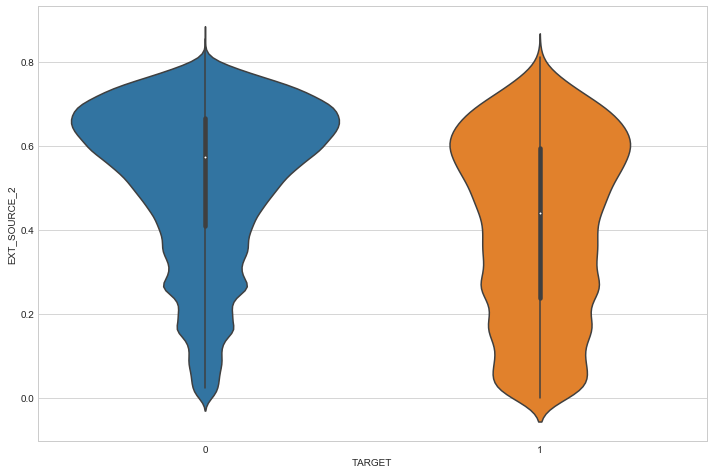

In [55]:
plt.figure(figsize=(12,8))
sns.violinplot(x ='TARGET', y = 'EXT_SOURCE_2', data = train)

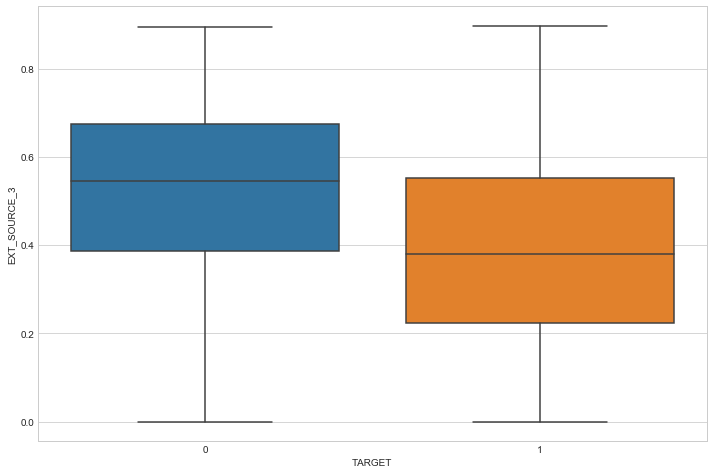

In [56]:
plt.figure(figsize=(12,8))
sns.boxplot(x ='TARGET', y = 'EXT_SOURCE_3', data = train)

In [ ]:
rc={'xtick.labelsize': 30, 'ytick.labelsize': 30, 'axes.labelsize': 30, 'font.size': 30, 'legend.fontsize': 25.0,
    'axes.titlesize': 30, "figure.figsize": [30, 10]}
sns.set(rc = rc)
sns.pointplot()

In [19]:
train['AGE'] = np.abs(train['DAYS_BIRTH']/365)

In [20]:
age_1 = train['AGE'].loc[train['TARGET'] == 1]
age_0 = train['AGE'].loc[train['TARGET'] == 0]

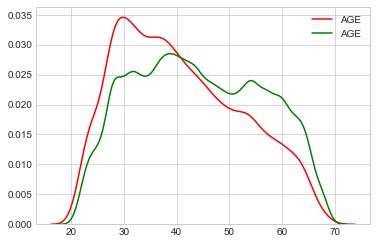

In [21]:
ax = sns.kdeplot(age_1, color = 'r')
ax = sns.kdeplot(age_0, color = 'g')



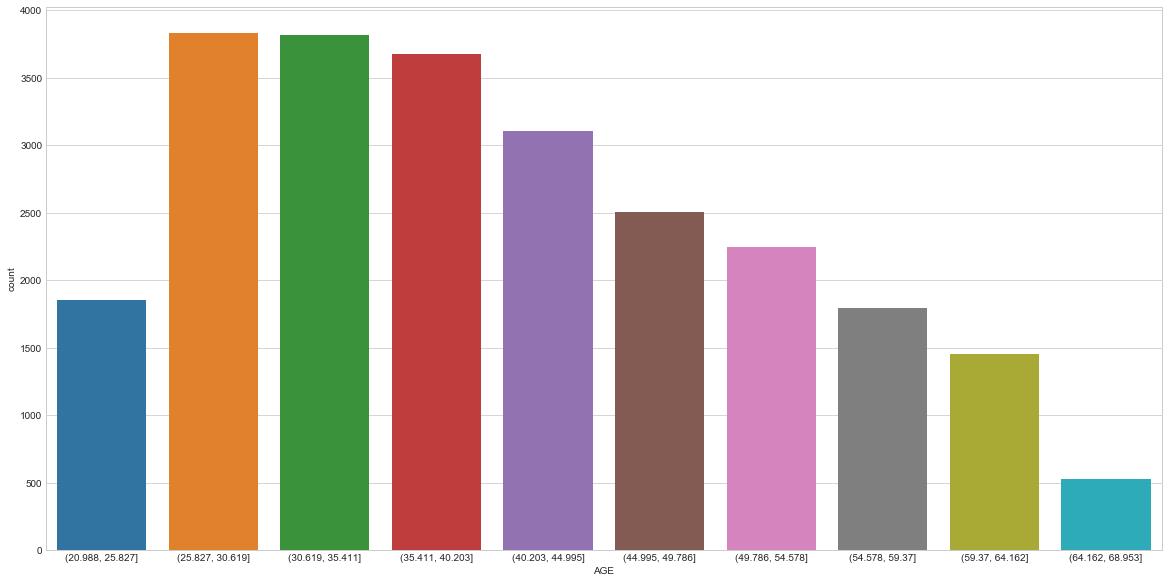

In [22]:
plt.figure(figsize = (20,10))
sns.countplot(pd.cut(age_1,10))

In [23]:
train['Years_Employed'] = np.abs(train['DAYS_EMPLOYED']/365)

In [24]:
employed_1 = train['Years_Employed'].loc[train['TARGET'] == 1]
employed_0 = train['Years_Employed'].loc[train['TARGET'] == 0]


In [25]:
train['Years_Employed'].isnull().any()

False

 train["years_Employed'] has a number which has the highest count. Looks like the missing values have been filled with 1000
 

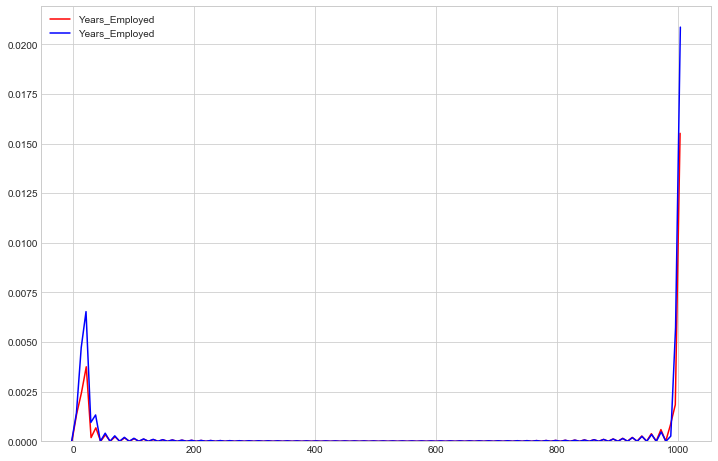

In [26]:
plt.figure(figsize = (12,8))
ax = sns.kdeplot(employed_1, color = 'r')
ax = sns.kdeplot(employed_0, color = 'b')

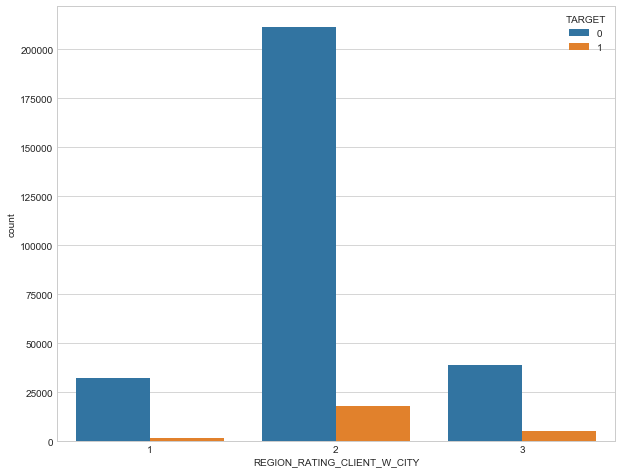

In [27]:
plt.figure(figsize=(10,8))
sns.countplot(x = 'REGION_RATING_CLIENT_W_CITY', hue='TARGET', data=train)

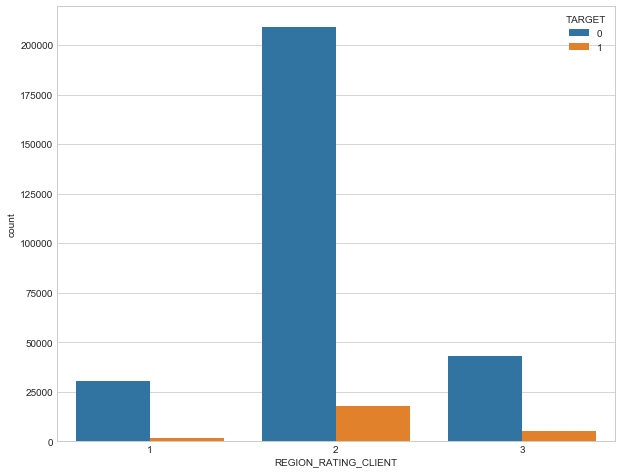

In [28]:
plt.figure(figsize=(10,8))
sns.countplot(x = 'REGION_RATING_CLIENT', hue='TARGET', data=train)

In [29]:
dup_cols = {}

for i, c1 in enumerate(train.columns):
    for c2 in train.columns[i + 1:]:
        if c2 not in dup_cols and np.all(train[c1] == train[c2]):
            dup_cols[c2] = c1

In [30]:
dup = (train['REGION_RATING_CLIENT_W_CITY'] == train['REGION_RATING_CLIENT']).reset_index()
dup.columns = ['Count', 'Value']

In [31]:
dup.groupby(['Value'])['Count'].count()

Value
False      5718
True     301793
Name: Count, dtype: int64

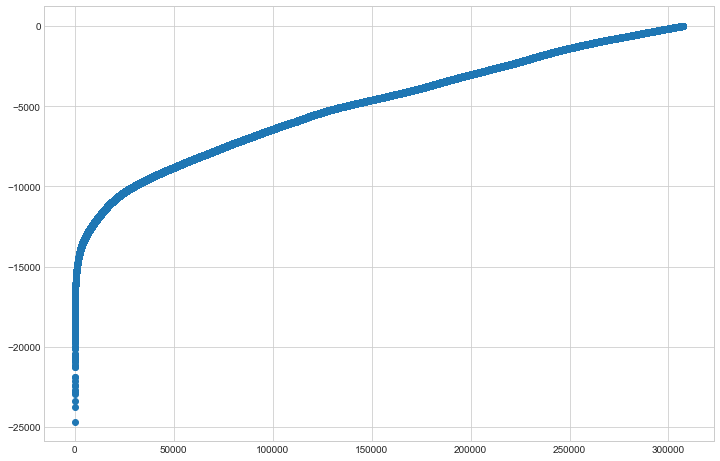

In [32]:
plt.figure(figsize=(12,8))
plt.scatter(range(train.shape[0]), np.sort(train['DAYS_REGISTRATION']))

In [33]:
registered_1 = np.abs(train['DAYS_REGISTRATION'].loc[train['TARGET'] == 1])
registered_0 = np.abs(train['DAYS_REGISTRATION'].loc[train['TARGET'] == 0])

In [34]:
registered_1 = np.log(registered_1)
registered_0 = np.log(registered_0)

/Users/krutarthmajithia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/Users/krutarthmajithia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


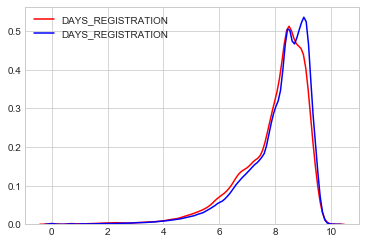

In [35]:
ax = sns.kdeplot(registered_1, color = 'r')
ax = sns.kdeplot(registered_0, color = 'b')

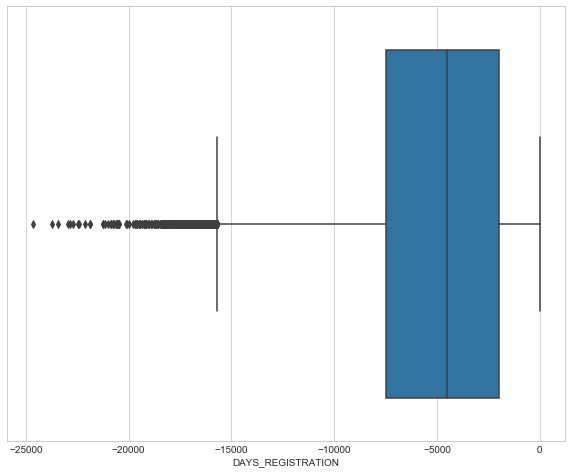

In [36]:
plt.figure(figsize = (10,8))
sns.boxplot(x = 'DAYS_REGISTRATION', hue='TARGET', data = train)

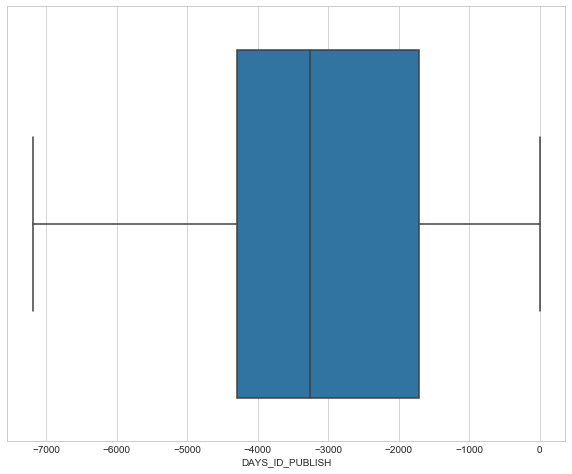

In [37]:
plt.figure(figsize = (10,8))
sns.boxplot(x = 'DAYS_ID_PUBLISH', hue='TARGET', data = train)

In [38]:
publish_1 = np.abs(train['DAYS_ID_PUBLISH'].loc[train['TARGET'] == 1])
publish_0 = np.abs(train['DAYS_ID_PUBLISH'].loc[train['TARGET'] == 0])


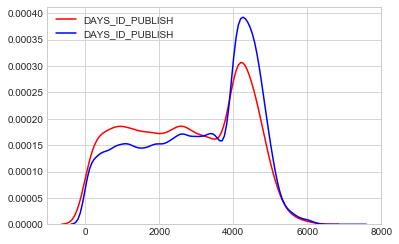

In [39]:
ax = sns.kdeplot(publish_1, color = 'r')
ax = sns.kdeplot(publish_0, color = 'b')

In [40]:
len(Numerical_cols)

106

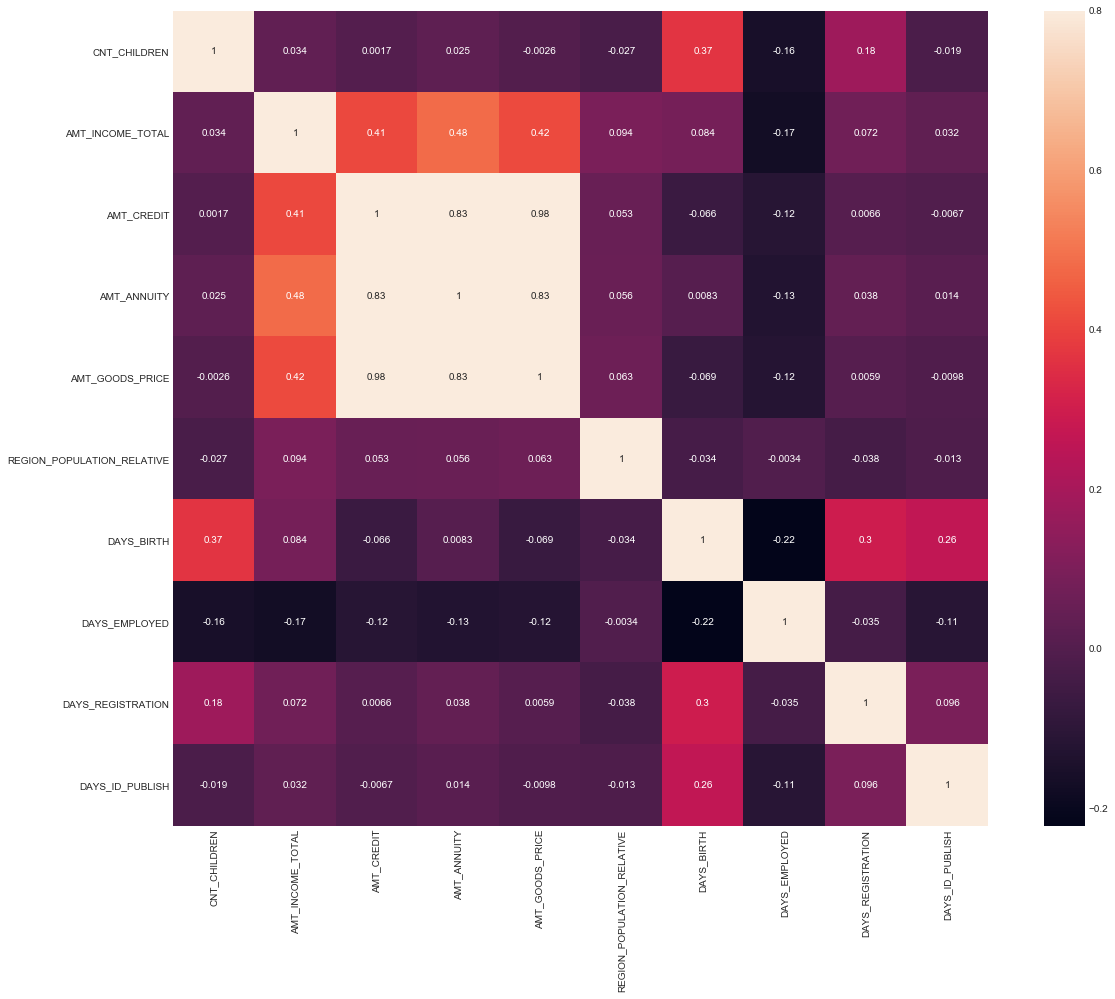

In [41]:
train_numerical_0 = train[Numerical_cols[2:12]]
corrmat = train_numerical_0.corr(method='spearman')
plt.subplots(figsize=(20,15))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True, annot= True)

Amt_credit is the one to be used

# Now we explore other datasets and its relationship with the train and test data


In [42]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [44]:
bureau['CREDIT_ACTIVE'].value_counts()

Closed      1079273
Active       630607
Sold           6527
Bad debt         21
Name: CREDIT_ACTIVE, dtype: int64

In [45]:
missing_data(bureau)

,Total,Percent
AMT_ANNUITY,1226791,71.473490
AMT_CREDIT_MAX_OVERDUE,1124488,65.513264
DAYS_ENDDATE_FACT,633653,36.916958
AMT_CREDIT_SUM_LIMIT,591780,34.477415
AMT_CREDIT_SUM_DEBT,257669,15.011932
DAYS_CREDIT_ENDDATE,105553,6.149573
AMT_CREDIT_SUM,13,0.000757
CREDIT_TYPE,0,0.000000
AMT_CREDIT_SUM_OVERDUE,0,0.000000
CNT_CREDIT_PROLONG,0,0.000000


In [46]:
bureau.dtypes

SK_ID_CURR                  int64
SK_ID_BUREAU                int64
CREDIT_ACTIVE              object
CREDIT_CURRENCY            object
DAYS_CREDIT                 int64
CREDIT_DAY_OVERDUE          int64
DAYS_CREDIT_ENDDATE       float64
DAYS_ENDDATE_FACT         float64
AMT_CREDIT_MAX_OVERDUE    float64
CNT_CREDIT_PROLONG          int64
AMT_CREDIT_SUM            float64
AMT_CREDIT_SUM_DEBT       float64
AMT_CREDIT_SUM_LIMIT      float64
AMT_CREDIT_SUM_OVERDUE    float64
CREDIT_TYPE                object
DAYS_CREDIT_UPDATE          int64
AMT_ANNUITY               float64
dtype: object

In [57]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [59]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN
